Python notebook for developing code. everything here will be lost at some point.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
from scipy.integrate import solve_ivp


In [ ]:

def lindblad_term(rho, a):
    return a@rho@np.conj(a.T) - .5*(np.conj(a.T)@a@rho + rho@np.conj(a.T)@a)

def commutator(A, B):
    return A@B - B@A

def lindblad_master_equation(t, rho_vec, hamiltonian, dissipation_channels):
    d = int(len(rho_vec)**.5)
    rho = rho_vec.reshape(d, d)
    drho = -1j*commutator(hamiltonian,rho) + np.sum([lindblad_term(rho, i) for i in dissipation_channels], axis=0)
    return drho.flatten()
    # if callable(hamiltonian):
    #     return commutator(hamiltonian(t),rho) + np.sum([lindblad_term(rho, i) for i in dissipation_channels], axis=0)
    # else

N = 20

cavity_diss_rate = 2*np.pi*4.3*10**6
input_power = 0
cavity_photon_number = 10**(input_power/10)
rabi_freq = 2*np.pi*9*10**6
eff_coupling = 2*np.pi*(1)*10**6
qubit_targetz = 9*2*np.pi*10**6
qubit_detuning = qubit_targetz + eff_coupling*(2*cavity_photon_number + 1) 

qubit_detuning_lamb_shift = qubit_detuning - eff_coupling*(2*cavity_photon_number + 1)
cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5

cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)

norm = 2*np.pi*10**6
final_time = 2 # in 1/Mhz
tlist = np.linspace(0, final_time, 10000)/(10**6)

tlist__N = tlist*norm
cavity_detuning__N = cavity_detuning/norm
cavity_drive_amplitude__N = cavity_drive_amplitude/norm
qubit_detuning__N = qubit_detuning/norm
eff_coupling__N = eff_coupling/norm
rabi_freq__N = rabi_freq/norm
cavity_diss_rate__N = cavity_diss_rate/norm

d = tensor(destroy(N), qeye(2))   
sz = tensor(qeye(N), sigmaz())  
sx = tensor(qeye(N), sigmax())     
sm = tensor(qeye(N), sigmam()) 

d_matrix = d.full()
sz_matrix = sz.full()
sx_matrix = sx.full()

H_cav = cavity_detuning__N * d.dag()*d + cavity_drive_amplitude__N * (d + d.dag())
H_qubit = -.5*(qubit_detuning__N - eff_coupling__N)*sz - .5*rabi_freq__N*sx
H_int =   eff_coupling__N*d.dag()*d*sz
H = H_cav + H_qubit + H_int

H_matrix = H.full()
d_matrix = d.full()
sz_matrix = sz.full()

dissipation_channels = [(cavity_diss_rate__N**.5*d_matrix)]

psi0_atom = basis(2,1)
psi0_cavity = coherent(N,cavity_field)
initial_state = tensor(psi0_cavity, psi0_atom)
rho0 = initial_state@initial_state.dag()
rho0_matrix = rho0.full()
rho0_vectorized = rho0_matrix.flatten()


max_step =  0.05/np.max([cavity_drive_amplitude__N, qubit_detuning__N, cavity_detuning__N,
                        rabi_freq__N, eff_coupling__N, cavity_diss_rate__N])

sol = solve_ivp(lindblad_master_equation, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853", t_eval=tlist__N, max_step=max_step, args=(H_matrix, dissipation_channels))

dynamics = sol.y.T.reshape(10000, 2*N, 2*N)

/tmp/ipykernel_67695/944791622.py:13: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  axes[0].plot(tlist*10**6, x, color='#000080', label= f"{round(xmean,2)}")
/tmp/ipykernel_67695/944791622.py:19: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  axes[1].plot(tlist*10**6, z, color='#008000', label= f"{round(zmean,2)}")


Text(0, 0.5, '$<a^\\dagger a>$')

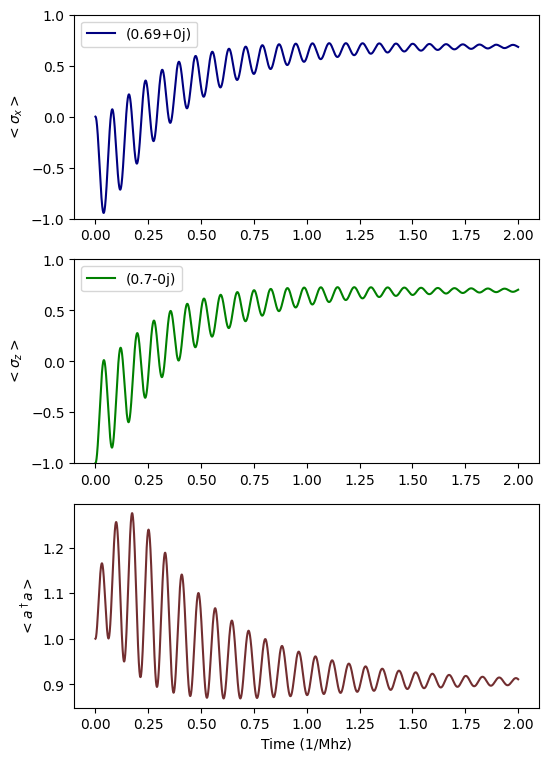

In [59]:
z = np.trace(dynamics@sz_matrix, axis1=1, axis2=2)
x = np.trace(dynamics@sx_matrix, axis1=1, axis2=2)
ph_number = np.trace(dynamics@(d_matrix.conj().T@d_matrix), axis1=1, axis2=2)

xmean = np.mean(x[-20:])
zmean = np.mean(z[-20:])

#Create the figures.
fig, axes = plt.subplots(3, 1, figsize=(6,9))

#fig.suptitle(fig_title)

axes[0].plot(tlist*10**6, x, color='#000080', label= f"{round(xmean,2)}")
#axes[0].set_xlabel('Time (1/Mhz)')
axes[0].set_ylabel(r'$ <\sigma_x >$')
axes[0].legend()
axes[0].set_ylim(-1, 1)

axes[1].plot(tlist*10**6, z, color='#008000', label= f"{round(zmean,2)}")
#axes[1].set_xlabel('Time (1/Mhz)')
axes[1].set_ylabel(r'$<\sigma_z >$')
axes[1].legend()
axes[1].set_ylim(-1, 1)

axes[2].plot(tlist*10**6, ph_number, color='#722E30')
axes[2].set_xlabel('Time (1/Mhz)')
axes[2].set_ylabel(r'$<a^\dagger a>$')

# print(  r'$n = $' + f'{cavity_photon_number},  ' + \
#         r'$ \Delta_q =$' + f'{round(qubit_detuning__N,3)},  ' + \
#         r'$\chi =$' + f'{round(eff_coupling__N,3)},   ' + \
#         r'$\kappa =$' + f'{round(cavity_diss_rate__N,3)},  ' + \
#         ' all normed by ' + r'$2 \pi Mhz.$' + \
#         r'$ Fidelity =$' + f'{round(fidel,3)},   ' + \
#         r'trace dist =' + f'{round(tr_dist,3)}.' )

In [94]:
def commutator(A, B):
    return A@B - B@A

def redfield_master_equation(t, rho_vec, hamiltonian, redfield_operators,
                             coupling_operators):
    
    d = int(len(rho_vec)**.5)
    rho = rho_vec.reshape(d, d)
    drho = -1j*commutator(hamiltonian,rho) + \
            np.sum([commutator(redfield_operators[i]@rho, coupling_operators[i]) for i in range(len(redfield_operators))], axis=0)  + \
            np.sum([commutator(coupling_operators[i].conj().T,rho.T@(redfield_operators[i].conj().T)) for i in range(len(redfield_operators))], axis=0)
        #     np.sum([commutator(redfield_operators[i]@rho, coupling_operators[i]) for i in range(len(redfield_operators))], axis=0).conj().T

    return drho.flatten()

N = 20

cavity_diss_rate = 2*np.pi*8*10**6
input_power = 0
cavity_photon_number = 10**(input_power/10)
rabi_freq = 2*np.pi*9*10**6
eff_coupling = 2*np.pi*(1)*10**6
qubit_targetz = 9*2*np.pi*10**6
qubit_detuning = qubit_targetz + eff_coupling*(2*cavity_photon_number + 1) 

qubit_detuning_lamb_shift = qubit_detuning - eff_coupling*(2*cavity_photon_number + 1)
cavity_detuning = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5

cavity_drive_amplitude = np.real((cavity_photon_number * (cavity_detuning**2 + .25*cavity_diss_rate**2))**.5)
cavity_field = cavity_drive_amplitude/(-cavity_detuning + .5j*cavity_diss_rate)

diag_qubit_freq = (qubit_detuning_lamb_shift**2 + rabi_freq**2)**.5
coupling_sz = eff_coupling*qubit_detuning_lamb_shift/diag_qubit_freq
coupling_sx = -eff_coupling*rabi_freq/diag_qubit_freq

tlist__N = tlist*norm
cavity_detuning__N = cavity_detuning/norm
cavity_drive_amplitude__N = cavity_drive_amplitude/norm
qubit_detuning__N = qubit_detuning/norm
eff_coupling__N = eff_coupling/norm
rabi_freq__N = rabi_freq/norm
cavity_diss_rate__N = cavity_diss_rate/norm
diag_qubit_freq__N = diag_qubit_freq/norm
coupling_sz__N = coupling_sz/norm
coupling_sx__N = coupling_sx/norm

sz = sigmaz()
sx = sigmax()
sm = sigmap()

sz_matrix = sz.full()
sx_matrix = sx.full()
sm_matrix = sm.full()


H_qubit_matrix = -.5*diag_qubit_freq__N*sz_matrix


u1 = cavity_photon_number*coupling_sz__N/(-1j*cavity_detuning__N - cavity_diss_rate__N/2)*sz_matrix \
    +  cavity_photon_number*coupling_sx__N/(-1j*(diag_qubit_freq__N + cavity_detuning__N) - cavity_diss_rate__N/2)*sm_matrix.T \
    +  cavity_photon_number*coupling_sx__N/(1j*(diag_qubit_freq__N - cavity_detuning__N) - cavity_diss_rate__N/2)*sm_matrix 

u2 = u1

s1 = coupling_sz__N*sz_matrix
s2 = coupling_sx__N*sx_matrix

u_op = [u1, u2]
s_op = [s1, s2]

psi0_atom = basis(2,1)
rho0 = psi0_atom@psi0_atom.dag()
rho0_matrix = rho0.full()
rho0_vectorized = rho0_matrix.flatten()


max_step =  0.05/np.max([cavity_drive_amplitude__N, qubit_detuning__N, cavity_detuning__N,
                        rabi_freq__N, eff_coupling__N, cavity_diss_rate__N])

sol = solve_ivp(redfield_master_equation, (tlist__N[0], tlist__N[-1]), rho0_vectorized, method="DOP853", t_eval=tlist__N, max_step=max_step, args=(H_qubit_matrix, u_op, s_op))

dynamics = sol.y.T.reshape(10000, 2, 2)

In [85]:
sm

Quantum object: dims=[[2], [2]], shape=(2, 2), type='oper', dtype=CSR, isherm=False
Qobj data =
[[0. 0.]
 [1. 0.]]

/tmp/ipykernel_67695/3297393094.py:12: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  axes[0].plot(tlist*10**6, x, color='#000080', label= f"{round(xmean,2)}")
/home/saha/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/saha/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/tmp/ipykernel_67695/3297393094.py:18: DeprecationWarning: The Python built-in `round` is deprecated for complex scalars, and will raise a `TypeError` in a future release. Use `np.round` or `scalar.round` instead.
  axes[1].plot(tlist*10**6, z, color='#008000', label= f"{round(zmean,2)}")


(-1.0, 1.0)

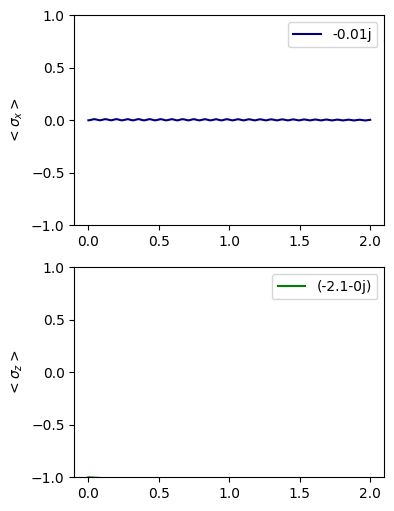

In [93]:
z = np.trace(dynamics@sz_matrix, axis1=1, axis2=2)
x = np.trace(dynamics@sx_matrix, axis1=1, axis2=2)

xmean = np.mean(x[-20:])
zmean = np.mean(z[-20:])

#Create the figures.
fig, axes = plt.subplots(2, 1, figsize=(4,6))

#fig.suptitle(fig_title)

axes[0].plot(tlist*10**6, x, color='#000080', label= f"{round(xmean,2)}")
#axes[0].set_xlabel('Time (1/Mhz)')
axes[0].set_ylabel(r'$ <\sigma_x >$')
axes[0].legend()
axes[0].set_ylim(-1, 1)

axes[1].plot(tlist*10**6, z, color='#008000', label= f"{round(zmean,2)}")
#axes[1].set_xlabel('Time (1/Mhz)')
axes[1].set_ylabel(r'$<\sigma_z >$')
axes[1].legend()
axes[1].set_ylim(-1, 1)

